#  Прогнозирование заказов такси

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Анализ-временного-ряда" data-toc-modified-id="Анализ-временного-ряда-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ временного ряда</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-влияния-признаков" data-toc-modified-id="Анализ-влияния-признаков-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Анализ влияния признаков</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.  Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Описание данных

Признаки:

-	`datetime` — время заказа такси
    
-	`num_orders`(от англ. *number of orders*, «число заказов») — количество заказов

Данные находятся в файле: `/datasets/taxi.csv` 

**Импортирование библиотек**

In [1]:
!pip -q install -U scikit-learn
!pip -q install catboost
!pip -q install shap

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

import catboost as cb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, OneHotEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [4]:
# Настройки вывода графиков
plt.rcParams["axes.titlesize"] = 16  # Размер шрифта
plt.rcParams["axes.titleweight"] = "bold"  # Толщина шрифта

# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.1

## Загрузка данных

In [5]:
try:
    taxi = pd.read_csv("C:\\Data-science\\ds_csv\\taxi.csv")
except:
    try:
        taxi = pd.read_csv('/datasets/taxi.csv')
    except:
        raise FileNotFoundError

In [6]:
taxi.info()
taxi.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


В данных отсутствуют пропуски, столбец `datetime` имеет некоректный тип данных

In [7]:
taxi["datetime"] = pd.to_datetime(taxi["datetime"])
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


- Данные числа заказов такси представлены в промежутке от 1 марта 2018 года до 31 августа 2018 года;
- Количество заказов от 0 до 119;
- Среднее число заказов - 14, медианное - 13.

In [8]:
taxi.set_index("datetime", inplace=True)
# Производим resample столбца datetime на 1 час
taxi = taxi.resample("H").sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
# Просмотр наличия пропусков
taxi[taxi.num_orders.isna()]

,num_orders
datetime,


**Вывод**:
- Столбец `datetime` имеет не подходящий тип данных.
- Данные числа заказов такси представлены в промежутке от 1 марта 2018 года до 31 августа 2018 года.
- Пропуски в данных отсутствуют.
- Было произведено ресемплирование данных по одному часу.

## Анализ временного ряда

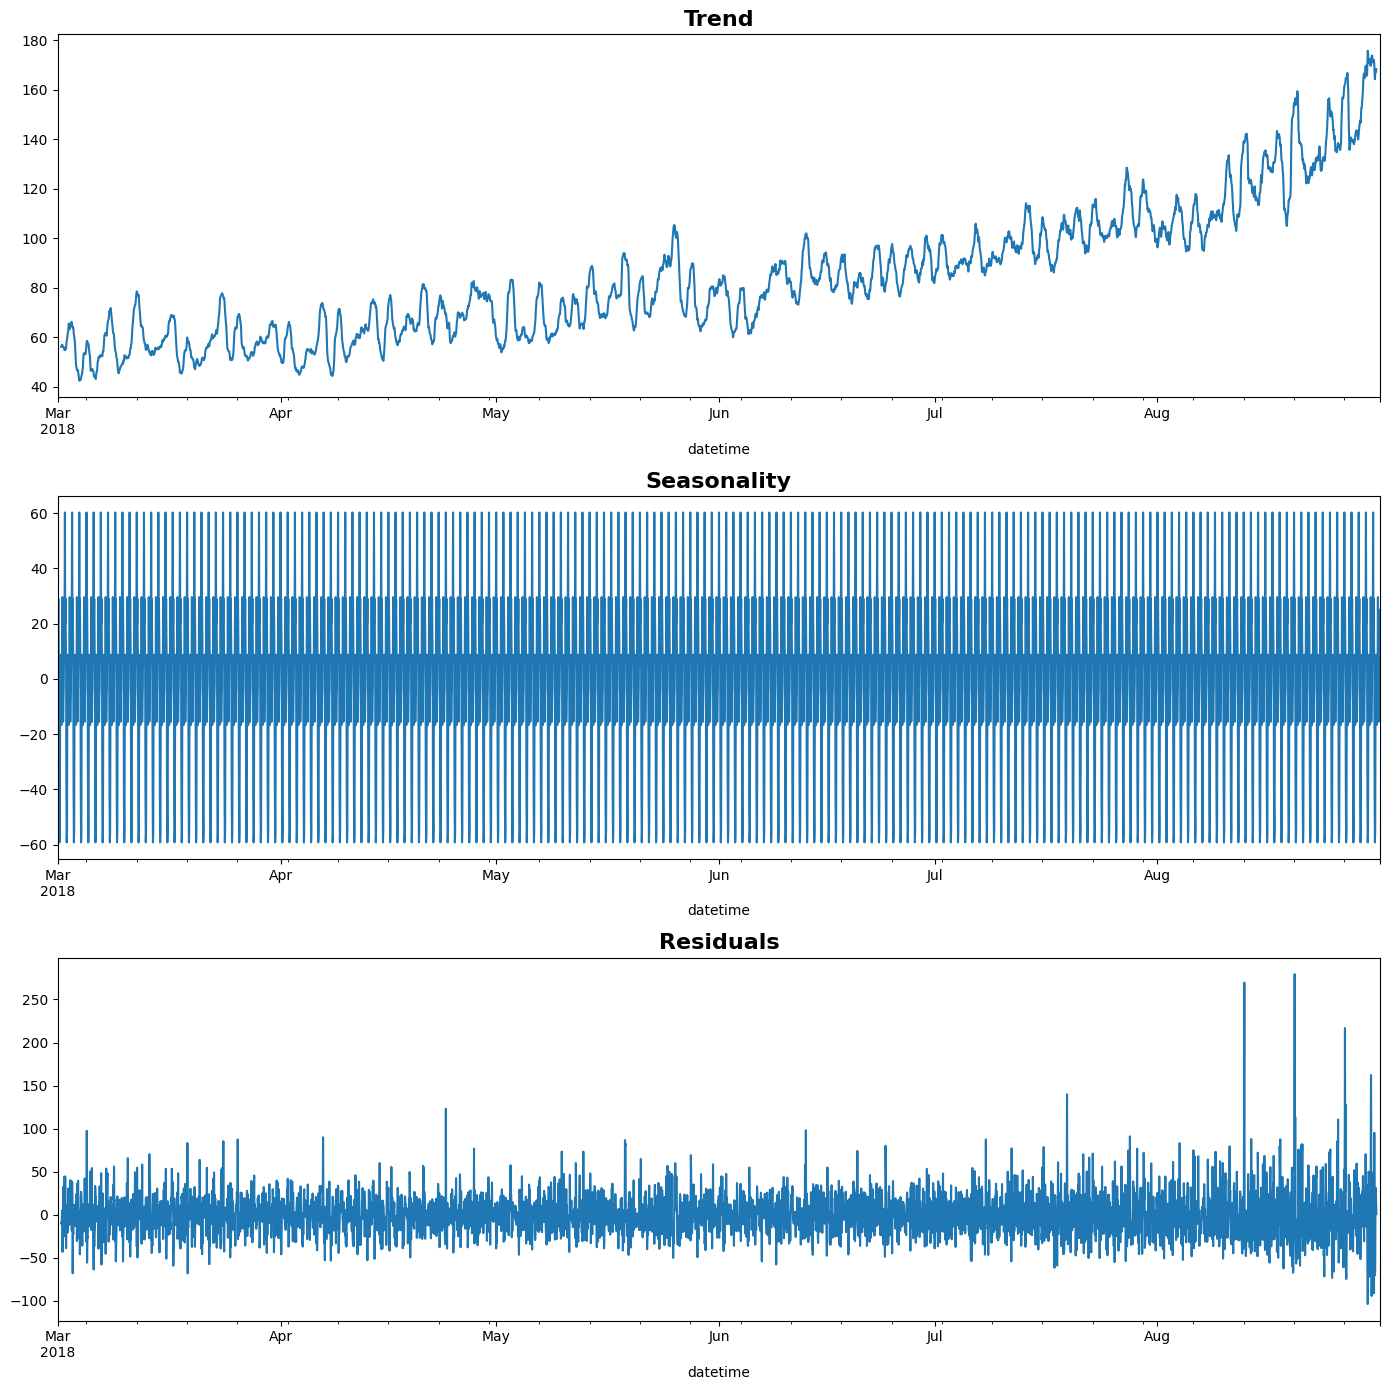

In [10]:
decomposed = seasonal_decompose(taxi)

# Построение графиков
plt.figure(figsize=(14, 14))

plt.subplot(3, 1, 1)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(3, 1, 2)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(3, 1, 3)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

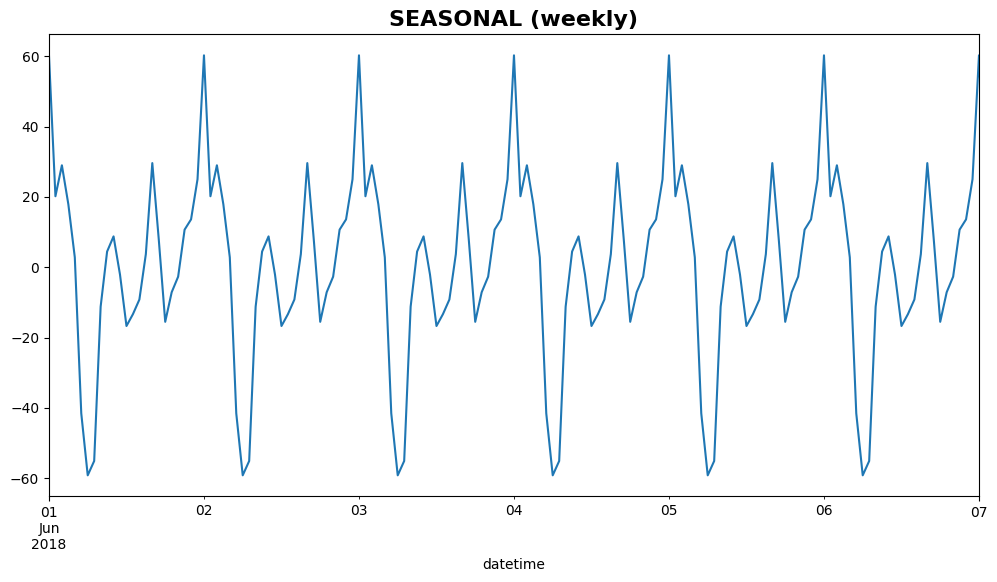

In [11]:
plt.figure(figsize=(12, 6))
decomposed.seasonal.plot()
plt.title('SEASONAL (weekly)')
plt.xlim(('2018-06-01', '2018-06-07'))
plt.show()

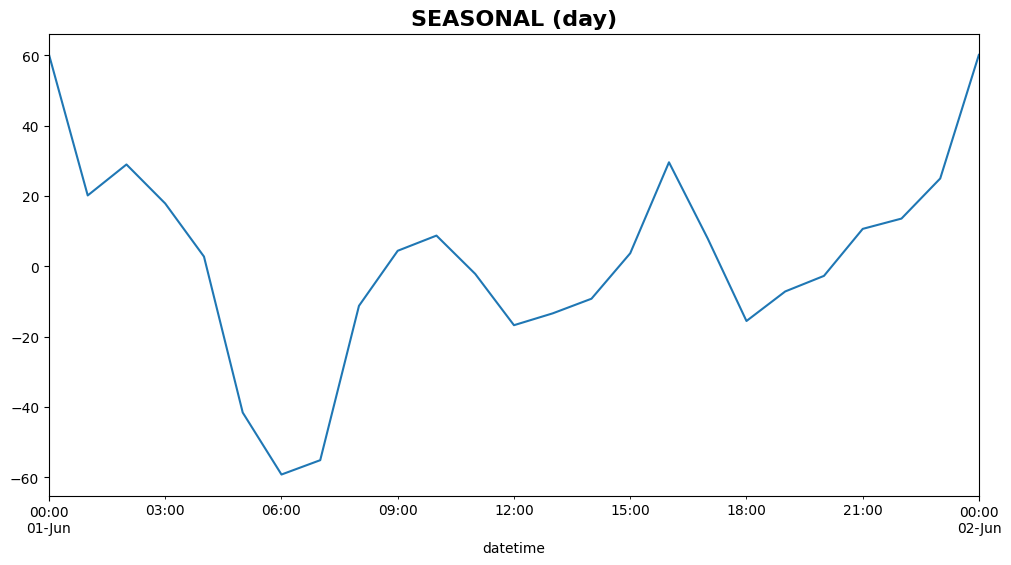

In [12]:
plt.figure(figsize=(12, 6))
decomposed.seasonal.plot()
plt.title('SEASONAL (day)')
plt.xlim(('2018-06-01', '2018-06-02'))
plt.show()

- Наблюдается тренд по увеличению числа заказов летом, особенно в июле и августе (может быть связано с началом сезона отпусков);
- В данных присутствует сезонность, со снижением числа заказов;
- Остатки не имеют какой-то явной закономерности.

<Figure size 1000x800 with 0 Axes>

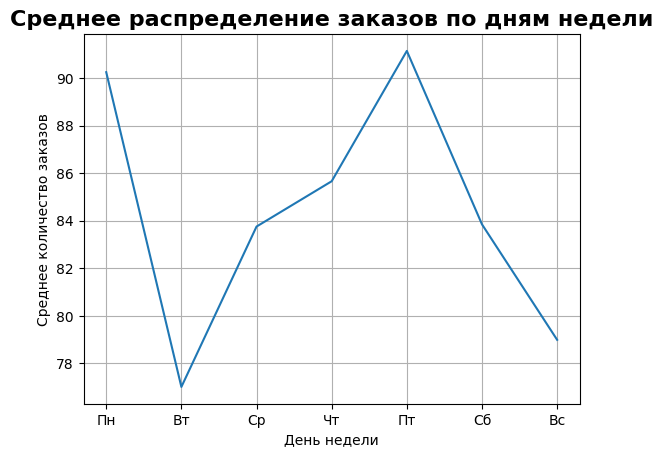

In [13]:
# Добавляем столбец 'day_of_week', который указывает на день недели (0 - понедельник, 6 - воскресенье)
taxi['day_of_week'] = taxi.index.dayofweek

# Создаём сводную таблицу для среднего количества заказов по дням недели
taxi_weekday_table = pd.pivot_table(taxi, values='num_orders', index='day_of_week', aggfunc='mean')

# Строим линейный график
plt.figure(figsize=(10, 8))
taxi_weekday_table.plot(kind='line', legend=False)
plt.title('Среднее распределение заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Среднее количество заказов')
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.grid(True)
plt.show()


- Замечено увеличения числа заказов в понедельник и пятницу (Возможно это связано с началом и концом рабочей недели).

<Figure size 1000x800 with 0 Axes>

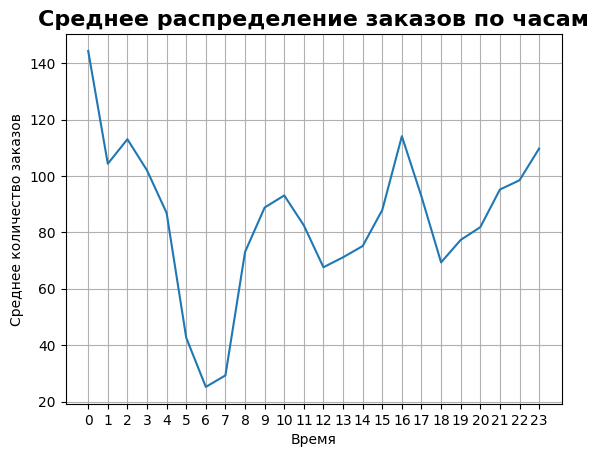

In [14]:
# Добавляем столбец 'hour', который указывает на время заказа в часах (от 0 до 23)
taxi['hour'] = taxi.index.hour

# Создаём сводную таблицу для среднего количества заказов по часам
taxi_weekday_table = pd.pivot_table(taxi, values='num_orders', index='hour', aggfunc='mean')

# Строим линейный график
plt.figure(figsize=(10, 8))
taxi_weekday_table.plot(kind='line', legend=False)
plt.title('Среднее распределение заказов по часам')
plt.xlabel('Время')
plt.ylabel('Среднее количество заказов')
plt.xticks(ticks=range(0, 24))
plt.grid(True)
plt.show()

- Наблюдается просадка кол-ва заказов во временном промежутке от 4 до 8 часов

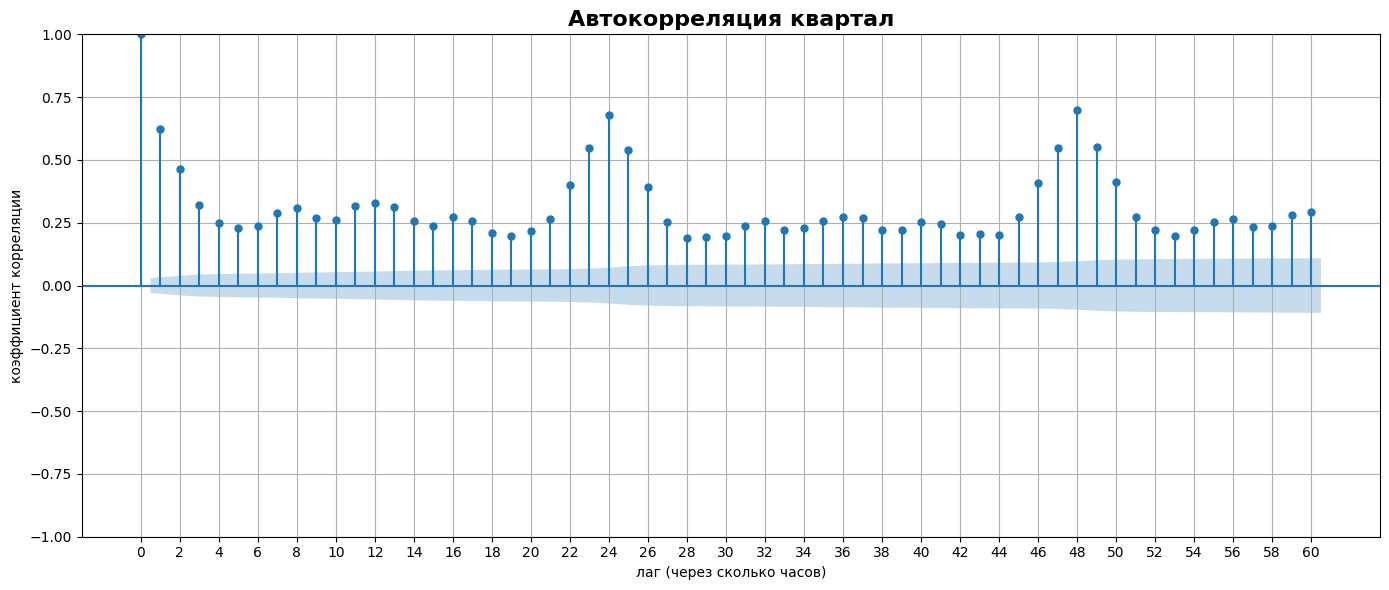

In [15]:
fig, ax = plt.subplots(figsize=(14, 6))
plot_acf(taxi["num_orders"].values, lags=60, ax=ax)
ax.set_title("Автокорреляция квартал")
ax.set_xlabel("лаг (через сколько часов)")
ax.set_ylabel("коэффициент корреляции")
ax.grid(True)
ax.set_xticks(np.arange(0, 61, 2))  # Метки через 2 дня
plt.tight_layout()
plt.show()

- Наблюдается повторение значений коэффициентов корреляции каждые 24 часа. Примем значение за размер скользящего окна и количества лагов.

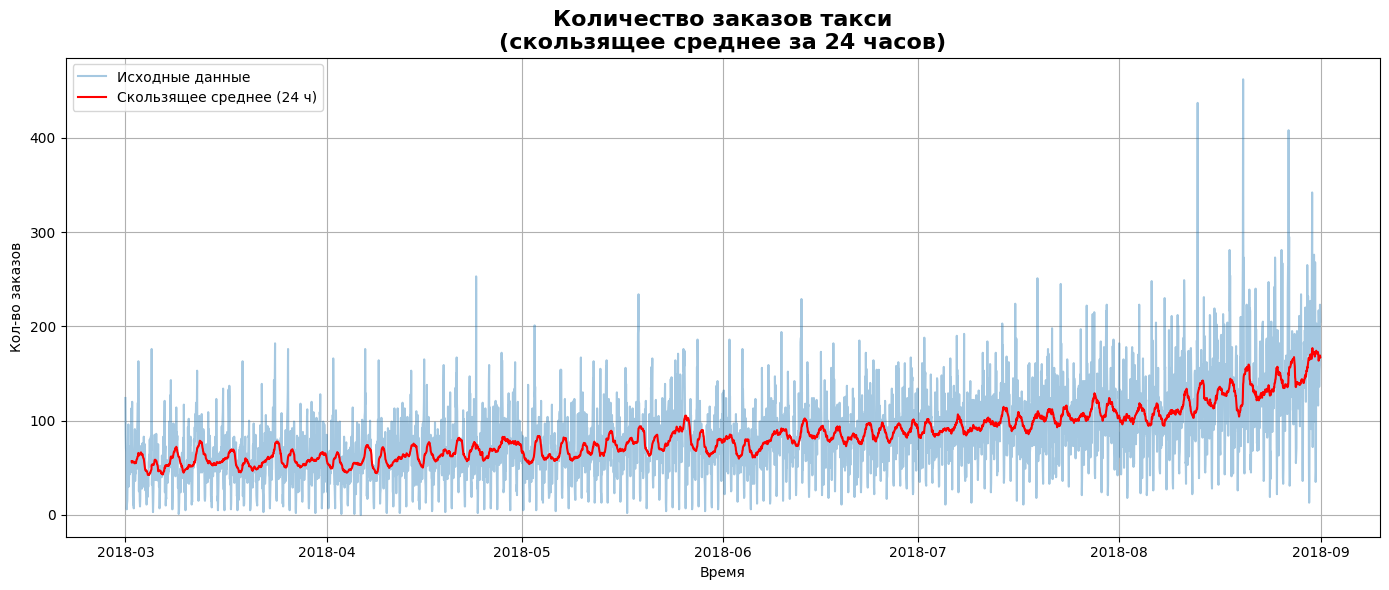

In [16]:
w = 24

plt.figure(figsize=(14, 6))
plt.plot(taxi.index, taxi["num_orders"], label="Исходные данные", alpha=0.4)
plt.plot(
    taxi.index,
    taxi["num_orders"].rolling(window=w).mean(),  # рассчитываем скользящее среднее прямо внутри plt.plot
    label=f"Скользящее среднее ({w} ч)",
    color='red'
)

plt.title(f"Количество заказов такси\n(скользящее среднее за {w} часов)")
plt.xlabel("Время")
plt.ylabel("Кол-во заказов")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод:**

- Наблюдается тренд по увеличению числа заказов летом, особенно в июле и августе (может быть связано с началом сезона отпусков).
- В данных присутствует сезонность, наблюдается повторение значений коэффициентов корреляции каждые 24 часа. Примем значение за размер скользящего окна и количества лагов.
- Остатки не имеют какой-то явной закономерности.
- Замечено увеличения числа заказов в понедельник и пятницу.

## Обучение модели

**Создание дополнительных признаков**

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['day_of_week'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()    
    return df

In [18]:
data_ml = make_features(taxi, 24, 24)
data_ml.head()

,num_orders,day_of_week,hour,day,month,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделение данных на тренировочную и тестовую выборку в соотношении 9:1

In [19]:
X = data_ml.drop(['num_orders'], axis=1)

# Удаление пропусков
X = X.dropna()
y = data_ml.loc[X.index, 'num_orders']

# Проверка
print("Размерность входных признаков", X.shape)
print("Размерность целевого признака", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=TEST_SIZE)

Размерность входных признаков (4392, 29)
Размерность целевого признака (4392,)


In [20]:
cat_features = ['day_of_week', 'hour', 'day', 'month']

# Массив всех признаков
num_features = [col for col in X_train.columns if col not in cat_features]

In [21]:
# Препроцессинг: масштабирование числовых и one-hot кодирование категориальных признаков
num_transformer = Pipeline([
    ('scaler', StandardScaler())  
])

cat_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())  
])

param_grid = [
    {
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__cat__onehot': [OneHotEncoder(handle_unknown='ignore', sparse_output=False)],
        'model': [LinearRegression()]
    },
    {
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__cat__onehot': [OneHotEncoder(handle_unknown='ignore', sparse_output=False)],
        'model': [Lasso()],
        'model__alpha': [0.01, 0.1, 1],
    },
    {
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__cat__onehot': [OneHotEncoder(handle_unknown='ignore', sparse_output=False)],
        'model': [Ridge()],
        'model__alpha': [0.01, 0.1, 1],
    },
    {
        'preprocessor__num__scaler': ['passthrough'],
        'preprocessor__cat__onehot': [OneHotEncoder(handle_unknown='ignore')],
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': [3, 5],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [2],
    },
    {
        'preprocessor__num__scaler': ['passthrough'],
        'preprocessor__cat__onehot': ['passthrough'],
        'model': [
            cb.CatBoostRegressor(
                random_state=RANDOM_STATE,
                verbose=100,
                loss_function='RMSE',
                iterations=1000,
                cat_features=cat_features
            )
        ]
    }
]

In [22]:
# Временная кросс-валидация
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    pipe,
    param_grid,
    n_jobs=-1,
    cv=tscv,
    scoring='neg_root_mean_squared_error'
)

grid_search.fit(X_train, y_train)

print(f"Лучший результат RMSE: {-grid_search.best_score_:.2f}")
print("Лучшие параметры:", grid_search.best_params_)

Лучший результат RMSE: 25.37
Лучшие параметры: {'model': Lasso(), 'model__alpha': 0.1, 'preprocessor__cat__onehot': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__num__scaler': StandardScaler()}


Проверка модели на тестовых данных

In [23]:
# Оценка на тестовой выборке
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"✅ RMSE на тестовых данных: {rmse:.1f}")

✅ RMSE на тестовых данных: 42.3


Показатель RMSE удовлетворяет условию задачи (не более 48)

**Вывод**

- Наилучшая модель Lasso c параметрами - 'model__alpha': 0.1, 'preprocessor__cat__onehot': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__num__scaler': StandardScaler();
- Результат RMSE на временной кросс-валидационной выборке 25.37;
- RMSE на тестовых данных: 42.3.

## Проверка модели на адекватность

Проверим данную модель на адекватность сравнив её с моделью DummyRegressor на тестовой выборке, модель делает предсказание как среднее или медианное значение

In [38]:
from sklearn.dummy import DummyRegressor

dummy_grid = [
    {
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__cat__onehot': [OneHotEncoder(handle_unknown='ignore')],
        'model': [DummyRegressor()],
        'model__strategy': ['mean']
    }
]

grid_search_dummy = GridSearchCV(
    pipe,
    dummy_grid,
    n_jobs=-1,
    cv=tscv,
    scoring='neg_root_mean_squared_error'
)

grid_search_dummy.fit(X_train, y_train)

# Вывод результатов
print(f"Лучший результат RMSE: {-grid_search_dummy.best_score_:.2f}")
print("Лучшие параметры:", grid_search_dummy.best_params_)

Лучший результат RMSE: 40.53
Лучшие параметры: {'model': DummyRegressor(), 'model__strategy': 'mean', 'preprocessor__cat__onehot': OneHotEncoder(handle_unknown='ignore'), 'preprocessor__num__scaler': StandardScaler()}


In [25]:
dummy_model = grid_search_dummy.best_estimator_
y_pred_dummy = dummy_model.predict(X_test)
rmse_dummy = np.sqrt(mean_squared_error(y_test, y_pred_dummy))
print(f"✅ RMSE на тестовых данных: {rmse_dummy:.2f}")

✅ RMSE на тестовых данных: 84.69


In [45]:
print(f"✅ Полученная модель предсказывает лучше среднего на: {(1 - rmse/rmse_dummy)*100:.0f}% на тестовых данных")

✅ Полученная модель предсказывает лучше среднего на: 50% на тестовых данных


**Вывод**

Модель Lasso c параметрами - 'model__alpha': 0.1, 'preprocessor__cat__onehot': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__num__scaler': StandardScaler() предсказывает лучше среднего на: 50% на тестовых данных

## Анализ влияния признаков

PermutationExplainer explainer: 441it [00:10,  1.02s/it]                         


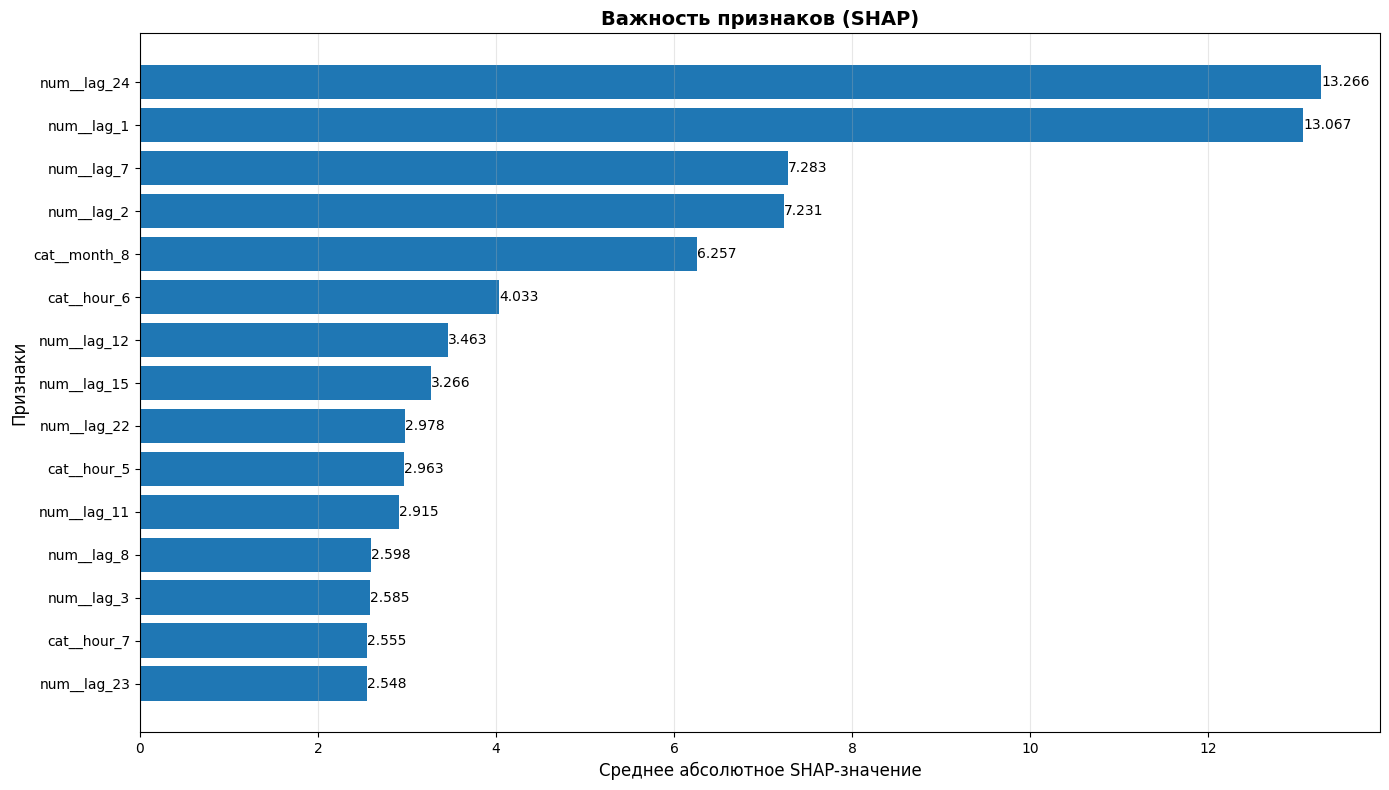

In [37]:
# Выборка данных
X_train_sample = shap.sample(X_train, 500)
X_test_sample = shap.sample(X_test, 500)

# Преобразование данных
preprocessor = grid_search.best_estimator_['preprocessor']
X_train_transformed = preprocessor.fit_transform(X_train_sample)
X_test_transformed = preprocessor.transform(X_test_sample)
feature_names = preprocessor.get_feature_names_out()

# Создание Explainer
explainer = shap.Explainer(
    model=grid_search.best_estimator_['model'].predict,
    masker=X_train_transformed
)
shap_values = explainer(X_test_transformed)

# Создание своего bar-plot вручную
mean_shap = np.abs(shap_values.values).mean(0)
sorted_idx = np.argsort(mean_shap)[-15:]  # Топ-15 признаков

# Подготовка данных для графика
features_sorted = [feature_names[i] for i in sorted_idx]
values_sorted = mean_shap[sorted_idx]

# Построение графика
plt.figure(figsize=(14, 8))
bars = plt.barh(features_sorted, values_sorted, color='#1f77b4')

# Добавление значений на столбцы
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', 
             ha='left', va='center', fontsize=10)

# Оформление
plt.xlabel('Среднее абсолютное SHAP-значение', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.title('Важность признаков (SHAP)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**Вывод**

Наибольшее влияние на предсказание модели Lasso оказывают входные признаки `num_lag_24`, `num_lag_1`, `num_lag_7` и `num_lag_2`.

## Общий вывод

1. Загружены данные заказов такси компании «Чётенькое такси». Данные предоставлены на период с марта по август 2018 года.
2. Выполнили их ресемплирование по одному часу.
3. Проанализировали данные, определив тренд на увеличение числа заказов летом и сезонность.
4. Изучили закономерности и обнаружили увеличение числа заказов в понедельник и пятницу.
5. Нашли оптимальные значения смещением = 24 и размер скользящего окна = 24.
6. Обучили в пайплайне модели LinearRegressor, Lasso, Ridge, DecisionTreeRegressor и CatBoostRegressor с различными гиперпараметрами, сделав тестовую выборку размером 10% от исходных данных.
7. Подобрали гиперпараметры c помощью GridSearchCV для каждой модели с минимальным значением метрики RSME.
8. Лучшей моделью с минимальной метрикой RSME = 42.3 на тестовой выборке оказалась модель Lasso - категориальные признаки каторой закодированы OneHotEncoder(), численные StandardScaler(), а значение коэффициента альфа = 0.1.
9. Определили влияние входных признаков на модель.